## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from fuzzywuzzy import process
import re

import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

## **1. Prepare the data**

- **Combine and Annotate Seasonal Data from Multiple CSV Files**

In [27]:
def load_and_combine_csv(directory_path, output_name='combined_df', row_limit=None):
    """
    Load and combine CSV files from a directory, adding a Season column.
    
    Parameters:
    directory_path (str): Path to the directory containing CSV files
    output_name (str): Name for the output variable (for print statements)
    row_limit (int, optional): Limit rows per file, if specified
    
    Returns:
    pandas.DataFrame: Combined DataFrame with Season column
    """
    all_files = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory_path, filename)
            all_files.append(file_path)
    
    # Initialize an empty list to store DataFrames
    dataframes = []
    
    # Process each file
    for file_path in all_files:
        # Extract the season from the filename
        season = os.path.basename(file_path).split('_')[-1].replace('.csv', '')
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Apply row limit if specified
        if row_limit is not None:
            df = df.head(row_limit)
        
        # Add a new column 'Season' with the extracted season value
        df['Season'] = season
        
        # Append the DataFrame to the list
        dataframes.append(df)
    
    # Concatenate all DataFrames into a single DataFrame
    result_df = pd.concat(dataframes, ignore_index=True)
    
    # Print the number of CSV files concatenated and the shape of the resulting DataFrame
    num_files = len(all_files)
    print(f"Number of CSV files concatenated: {num_files}")
    print(f"Shape of the resulting dataframe: {result_df.shape}")
    
    return result_df

In [28]:
# For the first case (Premier League data)
print("Loading Premier League stat data...")
premier_league_df = load_and_combine_csv('/Users/fitsumbahlebi/Desktop/repo2/EPL/Data/Raw/Premier_League', 'premier_league_df')
print("==============================================================")
print("Loading Premier League market value data...")
# For the second case (Market value data, with row limit)
market_value_df = load_and_combine_csv('/Users/fitsumbahlebi/Desktop/repo2/EPL/Data/Raw/Market_value', 'market_value_df', row_limit=20)

Loading Premier League stat data...
Number of CSV files concatenated: 18
Shape of the resulting dataframe: (6750, 166)
Loading Premier League market value data...
Number of CSV files concatenated: 18
Shape of the resulting dataframe: (360, 3)


## **2.Normalization**

### **1. Normalize Season Identifier**

In [29]:
def normalize_season(df, season_column="Season"):
    """
    Normalizes the season column to the format 'YYYY-YYYY+1'.
    """
    def format_season(season):
        if '-' not in season:
            start_year = int(season)
            return f"{start_year}-{start_year + 1}"
        return season
    
    df[season_column] = df[season_column].apply(format_season)
    return df

### **2. Normalize Team Names**

In [30]:
def normalize_team_names(df, column_mapping, predefined_mapping):
    """
    Normalizes team names using a predefined mapping and fuzzy matching.
    """
    from fuzzywuzzy import process

    # Replace using predefined mapping
    for col in column_mapping:
        df[col] = df[col].replace(predefined_mapping)

    # Extract unique team names
    unique_teams = set(df[column_mapping[0]].dropna().unique()).union(set(df[column_mapping[1]].dropna().unique()))
    unique_teams = [team for team in unique_teams if isinstance(team, str)]

    # Fuzzy match market_value_df teams to final_df teams
    mapping_dict = {}
    unmapped_teams = []  # To track unmapped teams
    for team in market_value_df['Club'].unique():
        if team in predefined_mapping:
            mapping_dict[team] = predefined_mapping[team]
        else:
            closest_match, score = process.extractOne(team, unique_teams)
            if score >= 90:
                mapping_dict[team] = closest_match
            else:
                mapping_dict[team] = team
                unmapped_teams.append(team)

    # Apply mapping to market_value_df
    market_value_df['Team'] = market_value_df['Club'].replace(mapping_dict)
    market_value_df.drop(columns=['Club'], inplace=True)

    # Sanity check: Log unmapped teams
    if unmapped_teams:
        print("Warning: The following teams could not be mapped confidently:")
        for team in unmapped_teams:
            print(f"- {team}")
    else:
        print("All teams mapped successfully.")

    return df, market_value_df



# Normalize season identifiers
market_value_df = normalize_season(market_value_df)

# Predefined mapping for known inconsistencies
predefined_mapping = {
    "Manchester City": "Man City",
    "Manchester United": "Man United",
    "Wolverhampton Wanderers": "Wolves",
    "Queens Park Rangers": "QPR",
    "Hull City": "Hull",
    "Nottingham Forest": "Nott'm Forest",
    "AFC Bournemouth": "Bournemouth",
    "Brighton & Hove Albion": "Brighton",
    "West Bromwich Albion": "West Brom",
    "Sheffield United": "Sheffield Utd",  
    "Sheffield Utd": "Sheffield United", 
    "Tottenham Hotspur": "Tottenham",
    "Leeds United": "Leeds",
    "Luton Town": "Luton",
    "Derby County": "Derby",
}
premier_league_df, market_df = normalize_team_names(premier_league_df, ["HomeTeam", "AwayTeam"], predefined_mapping)

All teams mapped successfully.


## **3. Merge datasets**

In [31]:
def merge_datasets(stats_df, market_value_df):
    """
    Merges stats and market value DataFrames on HomeTeam and AwayTeam.
    """
    for team_type in ["HomeTeam", "AwayTeam"]:
        stats_df = stats_df.merge(
            market_value_df[['Team', 'Season', 'Total Market Value']],
            left_on=[team_type, 'Season'],
            right_on=['Team', 'Season'],
            how='left'
        ).rename(columns={'Total Market Value': f"{team_type}_MarketValue"})
        stats_df.drop(columns=['Team'], inplace=True)
    return stats_df

# Merge datasets
epl_df = merge_datasets(premier_league_df, market_value_df)
print("All datasets merged successfully.")
print(f"Shape of the merged DataFrame: {epl_df.shape}")


All datasets merged successfully.
Shape of the merged DataFrame: (6750, 168)


## **4. EDA**

### **1. Dropping irrelevant :**
- I am going to start-off by dropping bookie columns that are not neccessary for this analysis. I am also going to drop any columns that had to do with stats happening during the game, such as:
    - **HTHG** = Half Time Home Team Goals
    - **HTAG** = Half Time Away Team Goals
    - **HTR** = Half Time Result (H=Home Win, D=Draw, A=Away Win)
    - **Season** = Season isn't needed also I only needed it to merge the datasets
    - **Div** = Division represents the league it's also not needed here.

In [41]:
# Drop uneccessary columns
columns_to_remove = [
    # Division ID and Season
    "Div","Season","Season",
    # Halftime results
    "HTHG", "HTAG", "HTR",
    
    # 1X2 Betting Odds
    "BFH", "BFD", "BFA", "BSH", "BSD", "BSA", "BWH", "BWD", "BWA", "GBH", "GBD", "GBA", 
    "IWH", "IWD", "IWA", "LBH", "LBD", "LBA", "PSH", "PH", "PSD", "PD", "PSA", "PA", 
    "SOH", "SOD", "SOA", "SBH", "SBD", "SBA", "SJH", "SJD", "SJA", "SYH", "SYD", "SYA", 
    "VCH", "VCD", "VCA", "WHH", "WHD", "WHA", "Bb1X2", "BbMxH", "BbAvH", "BbMxD", 
    "BbAvD", "BbMxA", "BbAvA", "MaxH", "MaxD", "MaxA", "AvgH", "AvgD", "AvgA", "BFEH", 
    "BFED", "BFEA",
    
    # Total Goals Betting Odds
    "BbOU", "BbMx>2.5", "BbAv>2.5", "BbMx<2.5", "BbAv<2.5", "GB>2.5", "GB<2.5", 
    "B365>2.5", "B365<2.5", "P>2.5", "P<2.5", "Max>2.5", "Max<2.5", "Avg>2.5", "Avg<2.5",
    
    # Asian Handicap Betting Odds
    "BbAH", "BbAHh", "AHh", "BbMxAHH", "BbAvAHH", "BbMxAHA", "BbAvAHA", 
    "GBAHH", "GBAHA", "GBAH", "LBAHH", "LBAHA", "LBAH", "B365AHH", "B365AHA", "B365AH", 
    "PAHH", "PAHA", "MaxAHH", "MaxAHA", "AvgAHH", "AvgAHA",
    
    # Closing Odds
    'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 
    'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 
    'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 
    'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 
    'MaxCAHA', 'AvgCAHH', 'AvgCAHA', '1XBH', '1XBD', '1XBA', 'BFE>2.5', 'BFE<2.5', 
    'BFEAHH', 'BFEAHA', 'BFCH', 'BFCD', 'BFCA', '1XBCH', '1XBCD', '1XBCA', 'BFECH', 
    'BFECD', 'BFECA', 'BFEC>2.5', 'BFEC<2.5', 'BFECAHH', 'BFECAHA',
    
    # Additional Odds
    'B365H', 'B365D', 'B365A', 'B365CH', 'B365CD', 'B365CA'
]


epl_df.drop(columns=columns_to_remove, inplace=True, errors='ignore')
print(epl_df.head())
print(epl_df.shape)


          Date       HomeTeam    AwayTeam  FTHG  FTAG FTR   Referee    HS  \
5139  01/01/08        Arsenal    West Ham   2.0   0.0   H     C Foy  21.0   
5140  01/01/08    Aston Villa   Tottenham   2.0   1.0   H  S Tanner  14.0   
5141  01/01/08         Fulham     Chelsea   1.0   2.0   A  M Halsey   5.0   
5142  01/01/08     Man United  Birmingham   1.0   0.0   H  P Walton  18.0   
5143  01/01/08  Middlesbrough     Everton   0.0   2.0   A   M Riley   7.0   

        AS   HST  ...    AF   HC   AC   HY   AY   HR   AR  Time  \
5139  15.0  13.0  ...   7.0  5.0  7.0  0.0  3.0  0.0  0.0   NaN   
5140   9.0   4.0  ...  16.0  8.0  2.0  0.0  3.0  0.0  0.0   NaN   
5141  11.0   2.0  ...   8.0  4.0  8.0  1.0  0.0  0.0  0.0   NaN   
5142  11.0  13.0  ...   8.0  2.0  0.0  1.0  4.0  0.0  0.0   NaN   
5143   5.0   4.0  ...  11.0  5.0  6.0  0.0  1.0  0.0  0.0   NaN   

      HomeTeam_MarketValue AwayTeam_MarketValue  
5139                €7.50m               €3.33m  
5140                €4.48m        

### **2. Dealing with nulls:**

In [42]:
# Check for the DataFramem information
print(epl_df.isnull().sum().sort_values(ascending=False))
print("===============================================")

Time                    4561
Date                       1
HomeTeam                   1
HomeTeam_MarketValue       1
AR                         1
HR                         1
AY                         1
HY                         1
AC                         1
HC                         1
AF                         1
HF                         1
AST                        1
HST                        1
AS                         1
HS                         1
Referee                    1
FTR                        1
FTAG                       1
FTHG                       1
AwayTeam                   1
AwayTeam_MarketValue       1
dtype: int64


In [43]:
# The time columns has way too many null values, so we will drop it
epl_df = epl_df.drop(columns=['Time'])
# Check for missing values in the DataFrame
print(epl_df.isnull().sum())

Date                    1
HomeTeam                1
AwayTeam                1
FTHG                    1
FTAG                    1
FTR                     1
Referee                 1
HS                      1
AS                      1
HST                     1
AST                     1
HF                      1
AF                      1
HC                      1
AC                      1
HY                      1
AY                      1
HR                      1
AR                      1
HomeTeam_MarketValue    1
AwayTeam_MarketValue    1
dtype: int64


In [44]:
# Drop remaining rows with missing values
epl_df = epl_df.dropna()

# Check for missing values in the DataFrame after dropping rows
print(epl_df.isnull().sum())
print("===============================================")
# Check the shape of the DataFrame after dropping rows
print(f"Shape of the DataFrame after dropping rows with missing values: {epl_df.shape}")

Date                    0
HomeTeam                0
AwayTeam                0
FTHG                    0
FTAG                    0
FTR                     0
Referee                 0
HS                      0
AS                      0
HST                     0
AST                     0
HF                      0
AF                      0
HC                      0
AC                      0
HY                      0
AY                      0
HR                      0
AR                      0
HomeTeam_MarketValue    0
AwayTeam_MarketValue    0
dtype: int64
Shape of the DataFrame after dropping rows with missing values: (6749, 21)


### **3. Manage data types:**

- The date column was in object data type, need to change it to datetime object.
- The numeric numbers(stats) should also be whole numbers.

In [45]:
def process_dataframe(df, date_column='Date', dayfirst=False, verbose=True):
    """
    Process a DataFrame by converting date columns and checking float columns for whole numbers.
    
    Parameters:
    df (pandas.DataFrame): DataFrame to process
    date_column (str): Name of the date column to convert, defaults to 'Date'
    dayfirst (bool): Whether dates are in day-first format, defaults to False
    verbose (bool): Whether to print detailed messages, defaults to True
    
    Returns:
    pandas.DataFrame: Processed DataFrame with converted date column
    """
    result_df = df.copy()
    
    # Process date column if it exists
    if date_column in result_df.columns:
        if verbose:
            print(f"Processing date column: '{date_column}'")
        
        # Step 1: Parse dates and keep them as datetime for logical operations
        result_df[date_column] = pd.to_datetime(result_df[date_column], errors='coerce', dayfirst=dayfirst)
        
        # Step 2: Check for parsing failures
        invalid_dates = result_df[result_df[date_column].isnull()]
        if not invalid_dates.empty:
            if verbose:
                print(f"Warning: {len(invalid_dates)} invalid dates found.")
                print(invalid_dates)
        else:
            if verbose:
                print("All dates are valid.")
        
        if verbose:
            print(f"Successfully converted '{date_column}' to datetime format.")
    else:
        if verbose:
            print(f"Date column '{date_column}' not found in DataFrame.")
    
    # Step 3: Check float columns for whole numbers
    float_columns = result_df.select_dtypes(include=['float']).columns
    
    if verbose and len(float_columns) > 0:
        print(f"\nChecking {len(float_columns)} float columns for whole numbers:")
    
    for col in float_columns:
        non_integers = result_df[~(result_df[col] % 1 == 0)]  # Rows where the value is not a whole number
        if not non_integers.empty:
            if verbose:
                print(f"Column '{col}' contains {len(non_integers)} non-integer values.")
                print(non_integers[[col]].head(5) if len(non_integers) > 5 else non_integers[[col]])
        else:
            if verbose:
                print(f"Column '{col}' contains only whole numbers.")
    
    # Summarize data types if verbose
    if verbose:
        print("\nDataFrame data types after processing:")
        print(result_df.dtypes)
    
    return result_df

# Process EPL dataframe
processed_epl_df = process_dataframe(epl_df)

Processing date column: 'Date'


/var/folders/3v/n_hcqvnj2q9bxvssr6zjwkc80000gp/T/ipykernel_4077/1836015478.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df[date_column] = pd.to_datetime(result_df[date_column], errors='coerce', dayfirst=dayfirst)


All dates are valid.
Successfully converted 'Date' to datetime format.

Checking 14 float columns for whole numbers:
Column 'FTHG' contains only whole numbers.
Column 'FTAG' contains only whole numbers.
Column 'HS' contains only whole numbers.
Column 'AS' contains only whole numbers.
Column 'HST' contains only whole numbers.
Column 'AST' contains only whole numbers.
Column 'HF' contains only whole numbers.
Column 'AF' contains only whole numbers.
Column 'HC' contains only whole numbers.
Column 'AC' contains only whole numbers.
Column 'HY' contains only whole numbers.
Column 'AY' contains only whole numbers.
Column 'HR' contains only whole numbers.
Column 'AR' contains only whole numbers.

DataFrame data types after processing:
Date                    datetime64[ns]
HomeTeam                        object
AwayTeam                        object
FTHG                           float64
FTAG                           float64
FTR                             object
Referee                      

### **4. Convert the HomeTeam_MarketValue and AwayTeam_MarketValue columns into numeric values:**

In [46]:
def convert_market_value(value):
    """
    Converts market value strings like '€7.60m' or '€1.89b' into numeric values in millions.
    """
    if isinstance(value, str):
        # Remove the currency symbol (€)
        value = value.replace('€', '').strip()
        
        # Check for suffix and convert accordingly
        if value.endswith('m'):  # Millions
            return float(value.replace('m', ''))
        elif value.endswith('b'):  # Billions
            return float(value.replace('b', '')) * 1000
        else:
            # If no suffix, assume it's already in millions
            return float(value)
    return value  # Return as-is if not a string

# Apply the conversion function to both columns
processed_epl_df['HT_MarketValue_inM'] = processed_epl_df['HomeTeam_MarketValue'].apply(convert_market_value)
processed_epl_df['AT_MarketValue_inM'] = processed_epl_df['AwayTeam_MarketValue'].apply(convert_market_value)

# Drop the original columns
processed_epl_df.drop(columns=['HomeTeam_MarketValue', 'AwayTeam_MarketValue'], inplace=True)

# Display the first few rows to verify the changes
print(processed_epl_df[['HT_MarketValue_inM', 'AT_MarketValue_inM']].head())

      HT_MarketValue_inM  AT_MarketValue_inM
5139                7.50                3.33
5140                4.48                5.80
5141                2.30               11.14
5142                9.33                2.50
5143                3.56                4.85


### **5. Check for non-alphanumeric characters left in the new columns:**

In [47]:
def check_non_alphanumeric(df, columns):
    for col in columns:
        # Convert column values to strings to avoid AttributeError
        df[col] = df[col].astype(str)
        
        # Check for rows with non-alphanumeric characters excluding decimal points
        non_alphanumeric_rows = df[df[col].str.contains(r'[^a-zA-Z0-9.\s]', na=False, regex=True)]
        if not non_alphanumeric_rows.empty:
            print(f"Non-alphanumeric characters found in column '{col}':")
            print(non_alphanumeric_rows[[col]])
        else:
            print(f"No non-alphanumeric characters found in column '{col}'.")
            # Convert the column to float
            df[col] = df[col].astype(float)

# Specify the columns to check
columns_to_check = ['HT_MarketValue_inM', 'AT_MarketValue_inM']  

# Apply the function to check for non-alphanumeric characters
check_non_alphanumeric(processed_epl_df, columns_to_check)

No non-alphanumeric characters found in column 'HT_MarketValue_inM'.
No non-alphanumeric characters found in column 'AT_MarketValue_inM'.


### **6. Check for Duplicates:**

In [48]:
# Check for duplicate rows
duplicates = processed_epl_df.duplicated()
if duplicates.any():
    print(f"Number of duplicate rows: {duplicates.sum()}")
else:
    print("No duplicate rows found.")

No duplicate rows found.


### **7. Check for inconsitent team names:**

In [49]:
epl_home = set(processed_epl_df['HomeTeam'].unique())
epl_away = set(processed_epl_df['AwayTeam'].unique())
# Check teams that are missing from either of home and away team
missing_teams = epl_home.symmetric_difference(epl_away)

# Display the missing teams
if missing_teams:
    print("Teams that are missing from either HomeTeam or AwayTeam:")
    for team in missing_teams:
        print(team)
else:
    print("No missing teams found.")


No missing teams found.


## **5. Relationship Between Features and the Target Variable**

### **1. Basic Match Outcome Analysis**

Match Outcome Distribution:
FTR
H    3059
A    2049
D    1641
Name: count, dtype: int64
Home win percentage: 45.33%
Away win percentage: 30.36%
Draw percentage: 24.31%


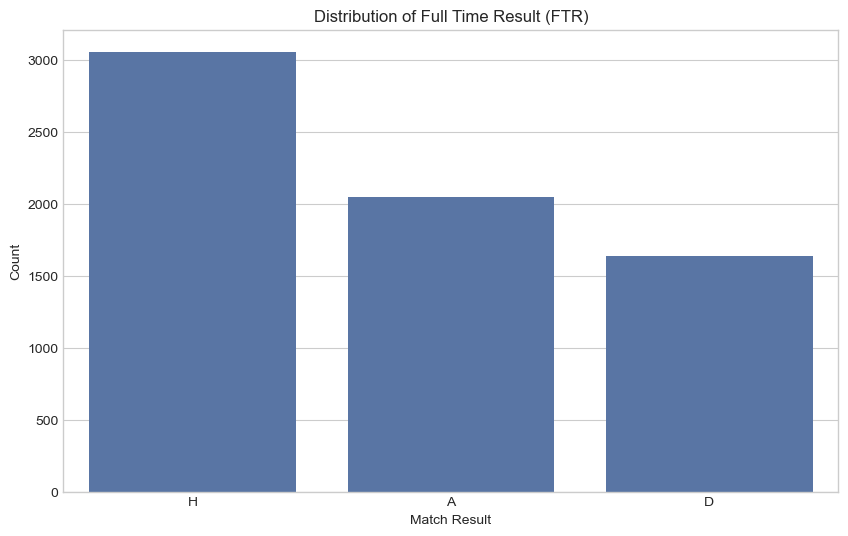

In [50]:
# Calculate outcome distribution
ftr_counts = processed_epl_df['FTR'].value_counts()
print("Match Outcome Distribution:")
print(ftr_counts)
print(f"Home win percentage: {ftr_counts['H']/len(processed_epl_df):.2%}")
print(f"Away win percentage: {ftr_counts['A']/len(processed_epl_df):.2%}")
print(f"Draw percentage: {ftr_counts['D']/len(processed_epl_df):.2%}")

# Visualize match outcomes
plt.figure(figsize=(10, 6))
sns.countplot(x='FTR', data=processed_epl_df, order=ftr_counts.index)
plt.title('Distribution of Full Time Result (FTR)')
plt.xlabel('Match Result')
plt.ylabel('Count')
plt.show()

- The data clearly shows a significant home advantage, with nearly half of the matches resulting in home wins.
- Away Wins: Away wins are less frequent, accounting for about 30% of the matches.
- Draws: Draws are the least common outcome, occurring in about 24% of the matches.

### **2. Market Value of Teams**

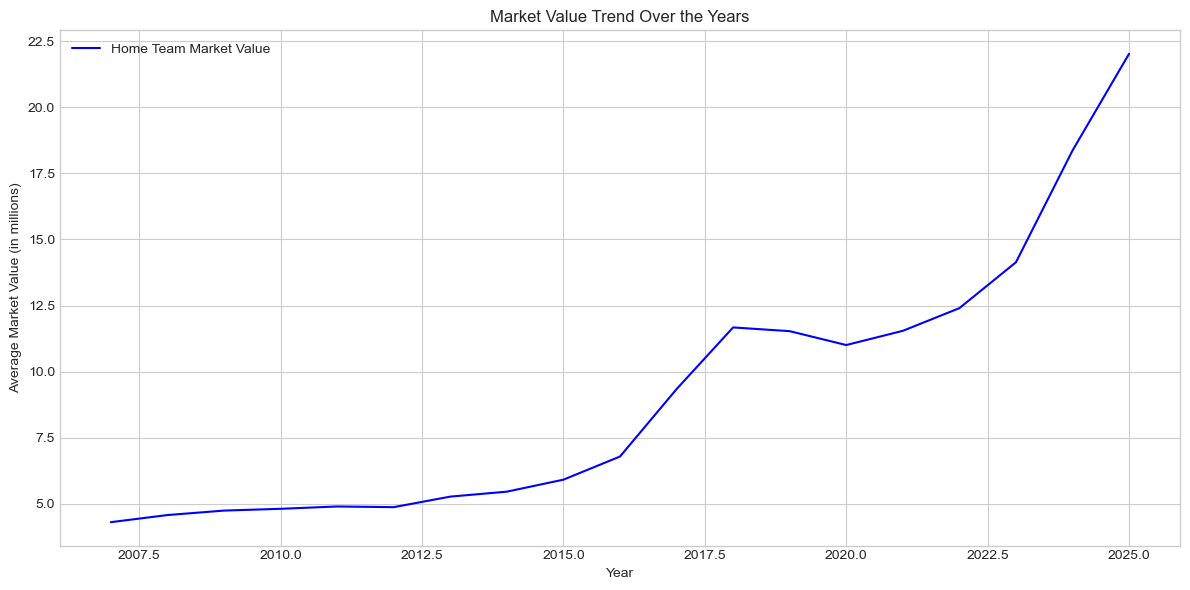

In [51]:
# Group by year and calculate the average market value for home and away teams
market_value_trend = (
    processed_epl_df.assign(Year=processed_epl_df['Date'].dt.year)
    .groupby('Year')[['HT_MarketValue_inM', 'AT_MarketValue_inM']]
    .mean()
    .reset_index()
)

# Plot the trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=market_value_trend, x='Year', y='HT_MarketValue_inM', label='Home Team Market Value', color='blue')
plt.title('Market Value Trend Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Market Value (in millions)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- It's no shock that team market values have been skyrocketing over the years, reflecting the growing financial investments and increasing competitiveness in football. This trend highlights the evolving economic dynamics of the sport, driven by heightened sponsorships, lucrative broadcasting deals, and the global fan base fueling these rising valuations.

### **3. Correlation Analysis**

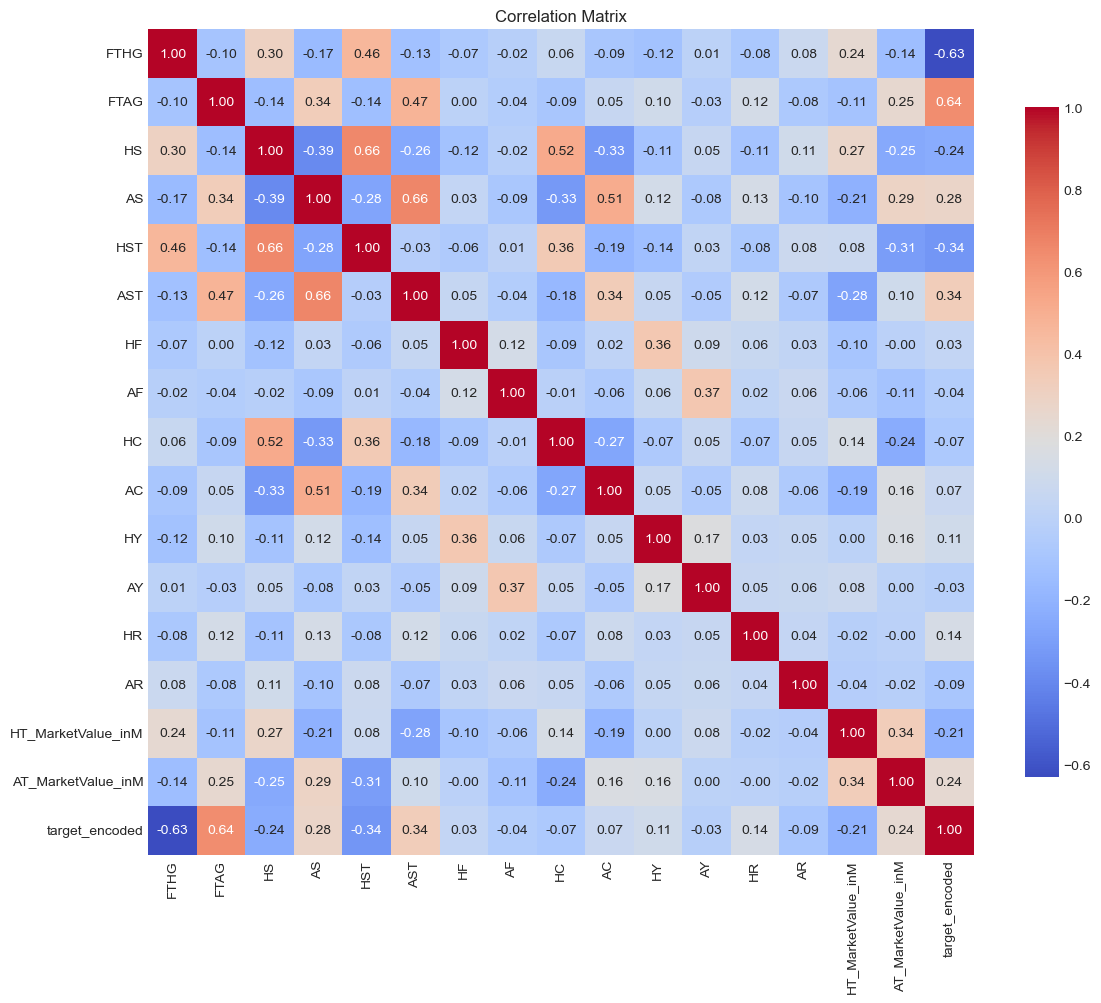

Correlation of features with the target variable:
target_encoded        1.000000
FTAG                  0.641970
AST                   0.336427
AS                    0.275396
AT_MarketValue_inM    0.240444
HR                    0.135654
HY                    0.106941
AC                    0.067140
HF                    0.032879
AY                   -0.025234
AF                   -0.038993
HC                   -0.072863
AR                   -0.093560
HT_MarketValue_inM   -0.206917
HS                   -0.238581
HST                  -0.339662
FTHG                 -0.631164
Name: target_encoded, dtype: float64


In [52]:
# Encode the target variable
processed_epl_df['target_encoded'] = processed_epl_df['FTR'].map({'H': 0, 'D': 1, 'A': 2})

# Calculate correlation matrix
numeric_cols = processed_epl_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Correlation with the target variable
correlation_with_target = correlation_matrix['target_encoded'].sort_values(ascending=False)
print("Correlation of features with the target variable:")
print(correlation_with_target)

### **Correlation Analysis Summary**

### Key Takeaways
   - **Strong predictors**: Goals (FTAG, FTHG) and Shots on Target (AST, HST) are the most impactful.  
   - **Moderate predictors:**: Shots on target (AST: 0.34, HST: -0.34) are more influential than total shots, and team market values (away: 0.24, home: -0.21) demonstrate meaningful impact on outcomes.  
   - **Weak predictors**: Features like fouls, cards, and corners have weak correlations.. 



## **6. Export Preprocessed data**
- The Data is now clean and ready for the next stage Feature Engineering and Data preparing.

In [53]:
# Save the cleaned DataFrame to a new CSV file
clean_output_dir = '/Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Data/Processed'
output_cleaned_file = os.path.join(clean_output_dir, 'epl_cleaned.csv')
# Drop the 'target_encoded' column
processed_epl_df.drop(columns=['target_encoded'], inplace=True)

# Save the cleaned DataFrame to a new CSV file
processed_epl_df.to_csv(output_cleaned_file, index=False)
print(f"Cleaned DataFrame saved to: {output_cleaned_file}")
# Display the shape of the cleaned DataFrame
print(f"Shape of the cleaned DataFrame: {processed_epl_df.shape}")

Cleaned DataFrame saved to: /Users/fitsumbahlebi/Desktop/repo2/PremierLeagueMatchPredictor/Data/Processed/epl_cleaned.csv
Shape of the cleaned DataFrame: (6749, 21)
